# Repetit

# Оглавление
* [Подготовка к работе](#1по_кр)
* [Загрузка и обзор данных](#1за_об)
    * [`teachers`](#1ти) 
    * [`teachers_info`](#1ти_ин)
    * [`lesson_course`](#1ле_ко)
    * [`lessons`](#1ле)
    * [`teacher_prices`](#1те_пр)
    * [`orders`](#1ор)
* [Создание новых признаков](#1со_но)
* [Подготовка данных](#1по_да)
    * [`DropCorrelatedFeatures`](#1др_ко)
    * [`IsolationForest`](#1из_фо)
    * [`SelectKBest`](#1се_бе)
    * [`ADASYN`](#1ад)
* [`Pipeline`](#1па)
* [`StackingClassifier`](#1ст_кл)
* [Тестирование лучших моделей](#1те_лу)
* [Матрица ошибок](#1ма_ош)
* [Выводы](#1вы)

## Подготовка к работе <a class="anchor" id="1по_кр"></a>

Подключим необходимые библиотеки.

In [1]:
from Repetit_functions import Repetit

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

from feature_engine.selection import DropCorrelatedFeatures

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import f1_score, precision_score, recall_score

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN

from lightgbm import LGBMClassifier

from collections import Counter
from copy import deepcopy

RANDOM_STATE = 1000000
import random
random.seed(RANDOM_STATE)

import warnings
warnings.filterwarnings('ignore')

Значительная часть кода данного проекта обёрнута в функции и вынесена в отдельный класс `Repetit` для сокращения количества кода и облегчения дальнейшего деплоя в докер контейнер. Подключим этот класс.

In [2]:
repetit = Repetit()

## Загрузка и обзор данных <a class="anchor" id="1за_об"></a>

Загрузим все предоставленные заказчиком данные и изучим их. Начнём с датасета `teachers`. В этом датасете находятся сгенерированные на основе имеющихся данных заказчиком препдоложительно значимые признаки и разметка по целевому признаку.

### `teachers` <a class="anchor" id="1ти"></a>

In [3]:
teachers_df = repetit.df_info('teachers')

id  lessons_delivered  mean_lesson_price  lessons_given  \
0  198013              470.0        1284.221748          469.0   
1  153845             1111.0         884.085028         1082.0   
2   42869              505.0        2500.000000          184.0   
3  127280              442.0        1879.338843          363.0   
4  283905              694.0        1252.434457          534.0   

   lessons_started_fraction  lessons_per_pupil  money_recieved  blocked  
0                  0.666667          78.166667        602300.0        0  
1                  0.358974          77.285714        956580.0        0  
2                  0.142857          61.333333        460000.0        0  
3                  0.150000          60.500000        682200.0        0  
4                  0.257143          59.333333        668800.0        0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656 entries, 0 to 1655
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1656 non-null   int64  
 1   lessons_delivered         1656 non-null   float64
 2   mean_lesson_price         1656 non-null   float64
 3   lessons_given             1656 non-null   float64
 4   lessons_started_fraction  1656 non-null   float64
 5   lessons_per_pupil         1656 non-null   float64
 6   money_recieved            1656 non-null   float64
 7   blocked                   1656 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 103.6 KB


None

id  lessons_delivered  mean_lesson_price  lessons_given  \
count    1656.000000        1656.000000        1656.000000    1656.000000   
mean   195700.558575         177.651570        1509.636125     104.064614   
std     87667.530193         336.451272         908.722960     217.635955   
min       458.000000           1.000000         200.000000       1.000000   
25%    130185.500000          12.000000         994.880952       8.000000   
50%    210036.500000          54.000000        1350.308642      30.000000   
75%    276014.500000         207.500000        1852.012502     103.000000   
max    317531.000000        5690.000000       15000.000000    3788.000000   

       lessons_started_fraction  lessons_per_pupil  money_recieved  \
count               1656.000000        1656.000000    1.656000e+03   
mean                   0.194887           9.872112    1.750237e+05   
std                    0.135023           9.601426    4.850086e+05   
min                    0.009901           1.000000    2.000000e+02   
25%                    0.105263           3.000000    9.000000e+03   
50%                    0.166667           7.094017    4.310000e+04   
75%                    0.250000          13.500000    1.483500e+05   
max                    1.000000          78.166667    1.116220e+07   

           blocked  
count  1656.000000  
mean      0.336353  
std       0.472604  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000

Пропуски отсутствуют, данные в корректных форматах, однако максимальные значения практически во всех столбцах сильно отличаются от средних (в отсутствии отрицательных значений), при этом третий квантиль значительно ближе к среднему, что говорит о наличии *выбросов*. Отметим для будущей обработки.

Посмотрим на баланс целевого признака.

In [4]:
teachers_df.blocked.value_counts(normalize=True)

blocked
0    0.663647
1    0.336353
Name: proportion, dtype: float64

33% преподавателей оказались неэффективными. Довольно много для платформы, но мало для того, чтобы сказать, что целевой признак сбалансирован. Учитывая небольшое общее количество размеченных объектов получим около 550 отрицательно размеченных строк, чего может не хватить для обучения модели. При подготовке данных нужно будет применить методы борьбы с *дисбалансом*.

Сразу стоит обозначить стратегию подготовки данных. Заказчик предоставил очень много данных, использовать их все абсолютно точно нельзя. Нужно пройти по всем датасетам и выделить признаки, которые могут быть полезны в определении неэффективных преподавателей. Так же можно сгенерировать новые признаки. В этом нам поможет ТЗ, в котором уже есть некоторый анализ возможных значимых признаков.

`teachers` разобрали, остальные датасеты будем открывать в порядке их упоминания заказчиком.

### `teachers_info`  <a class="anchor" id="1ти_ин"></a>

In [5]:
teachers_info_df = repetit.df_info('teachers_info')

id                 reg_date               birth_date  \
0  33  2007-12-24 19:26:46.000  1983-06-05 00:00:00.000   
1  46  2007-12-24 19:26:46.000  1980-02-12 00:00:00.000   
2  51  2007-12-24 19:26:46.000  1965-04-30 00:00:00.000   
3  52  2007-12-24 19:26:46.000  1988-07-06 00:00:00.000   
4  54  2007-12-24 19:26:46.000  1985-09-30 00:00:00.000   

       teaching_start_date  is_email_confirmed  lesson_duration  lesson_cost  \
0  1989-09-01 00:00:00.000                   0               60         1000   
1  2003-09-01 00:00:00.000                   0               60          500   
2  1988-09-01 00:00:00.000                   0               60         1500   
3  2006-09-01 00:00:00.000                   0               60         1000   
4  2004-01-01 00:00:00.000                   0               45          400   

   is_display             last_visited  is_pupils_needed  \
0           1  2022-10-24 16:48:38.410               1.0   
1           0                     None               1.0   
2           0  2022-09-26 09:43:56.123               1.0   
3           1  2020-04-03 15:53:50.867               0.0   
4           0                     None               1.0   

   is_cell_phone_confirmed  area_id  sex  orders_allowed  review_num  
0                        0        1    1               0           6  
1                        0        1    3               1           0  
2                        0        1    2               1           0  
3                        0        1    2               1           2  
4                        0        1    3               1           0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       307972 non-null  int64  
 1   reg_date                 307972 non-null  object 
 2   birth_date               307972 non-null  object 
 3   teaching_start_date      307972 non-null  object 
 4   is_email_confirmed       307972 non-null  int64  
 5   lesson_duration          307972 non-null  int64  
 6   lesson_cost              307972 non-null  int64  
 7   is_display               307972 non-null  int64  
 8   last_visited             235837 non-null  object 
 9   is_pupils_needed         11208 non-null   float64
 10  is_cell_phone_confirmed  307972 non-null  int64  
 11  area_id                  307972 non-null  int64  
 12  sex                      307972 non-null  int64  
 13  orders_allowed           307972 non-null  int64  
 14  revi

None

id  is_email_confirmed  lesson_duration   lesson_cost  \
count  307972.000000       307972.000000    307972.000000  3.079720e+05   
mean   157246.177036            0.012732        61.502978  5.325806e+02   
std     90198.005463            0.112114        15.061675  2.146357e+03   
min        33.000000            0.000000         1.000000  0.000000e+00   
25%     79390.750000            0.000000        60.000000  0.000000e+00   
50%    157384.500000            0.000000        60.000000  5.000000e+02   
75%    235434.250000            0.000000        60.000000  9.000000e+02   
max    312622.000000            1.000000       999.000000  1.021709e+06   

          is_display  is_pupils_needed  is_cell_phone_confirmed  \
count  307972.000000      11208.000000            307972.000000   
mean        0.658735          0.948162                 0.006910   
std         0.474135          0.221710                 0.082837   
min         0.000000          0.000000                 0.000000   
25%         0.000000          1.000000                 0.000000   
50%         1.000000          1.000000                 0.000000   
75%         1.000000          1.000000                 0.000000   
max         1.000000          1.000000                 1.000000   

             area_id            sex  orders_allowed     review_num  
count  307972.000000  307972.000000   307972.000000  307972.000000  
mean        8.488928       1.776892        0.860702       1.087859  
std        16.442877       0.467861        0.346258       4.863274  
min         0.000000       0.000000        0.000000       0.000000  
25%         1.000000       2.000000        1.000000       0.000000  
50%         1.000000       2.000000        1.000000       0.000000  
75%         6.000000       2.000000        1.000000       0.000000  
max       121.000000       3.000000        1.000000     381.000000

Отметим столбец `area_id` как потенциально значимые. Остальные признаки либо имеют слишком малое среднее (а для размеченных учителей их и вовсе мало), либо их лучше взять из других таблиц. `orders_allowed` в ходе проекта был заблокирован заказчиком, так как давал утечку. Возможно этот признак подразумевает ручную проверку преподавателя, то есть является аналогом целевого признака.

### lesson_course <a class="anchor" id="1ле_ко"></a>

In [6]:
lesson_course_df = repetit.df_info('lesson_course')

id  client_id  teacher_id  order_id  lesson_place  lesson_price  \
0  240884   427831.0      133738  718009.0             2          1000   
1  242243   429075.0      106838  720876.0             1             0   
2  242364   429089.0       14700  720912.0             1             0   
3  242476   428940.0      138783  721219.0             1             0   
4  242942   424704.0        3476  720891.0             4           600   

   is_active  lesson_duration             date_updated  \
0          1               60  2021-04-25 23:08:17.883   
1          0                0  2021-12-03 23:05:52.873   
2          0                0  2022-05-25 07:27:15.077   
3          0                0  2021-06-22 20:36:53.287   
4          0               60  2021-12-19 13:29:29.257   

         suspend_till_date  
0  2018-08-27 00:00:00.000  
1  2020-08-01 00:00:00.000  
2  2019-09-08 14:22:41.940  
3  2018-09-03 00:00:00.000  
4  2022-03-20 00:00:00.000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893438 entries, 0 to 893437
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 893438 non-null  int64  
 1   client_id          893437 non-null  float64
 2   teacher_id         893438 non-null  int64  
 3   order_id           890132 non-null  float64
 4   lesson_place       893438 non-null  int64  
 5   lesson_price       893438 non-null  int64  
 6   is_active          893438 non-null  int64  
 7   lesson_duration    893438 non-null  int64  
 8   date_updated       893438 non-null  object 
 9   suspend_till_date  893438 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 68.2+ MB


None

id     client_id     teacher_id      order_id   lesson_place  \
count  8.934380e+05  8.934370e+05  893438.000000  8.901320e+05  893438.000000   
mean   1.052919e+06  9.104992e+05  156999.072977  2.201949e+06       3.399830   
std    2.599766e+05  2.360247e+05   79431.722496  4.524514e+05       1.554386   
min    1.000000e+01  1.000000e+00      33.000000  1.100000e+01       0.000000   
25%    8.303462e+05  7.685850e+05   95659.000000  1.808246e+06       2.000000   
50%    1.053760e+06  9.266170e+05  160006.000000  2.219964e+06       4.000000   
75%    1.277182e+06  1.107521e+06  220809.000000  2.602854e+06       4.000000   
max    1.505419e+06  1.268616e+06  312244.000000  2.936670e+06       7.000000   

       lesson_price      is_active  lesson_duration  
count  8.934380e+05  893438.000000     8.934380e+05  
mean   1.284200e+03       0.222249    -4.737214e+03  
std    3.624318e+03       0.415758     3.213024e+06  
min    0.000000e+00       0.000000    -2.147484e+09  
25%    7.000000e+02       0.000000     6.000000e+01  
50%    1.000000e+03       0.000000     6.000000e+01  
75%    1.500000e+03       0.000000     6.000000e+01  
max    2.500000e+06       1.000000     8.032022e+06

Датасет содержит довольно много уроков, из них в процессе будут выделены только те, которые относятся к преподавателям из `teachers_df`. Помимо признаков для объединения таблиц интерес представляют `lesson_price`, как более информативный, нежели `teachers_info.lesson_cost`, потому что цена на урок может отличаться в зависимости от места и ученика. 

### lessons <a class="anchor" id="1ле"></a>

In [7]:
lessons_df = repetit.df_info('lessons')

id  lesson_course_id              lesson_date time_from   time_to  \
0  135797               347  2023-04-14 00:00:00.000  12:45:00  13:50:00   
1  283596            185756  2022-11-15 00:00:00.000  20:30:00  21:30:00   
2  322184            184189  2022-12-15 00:00:00.000  16:00:00  17:30:00   
3  371621            213849  2023-02-13 00:00:00.000  19:30:00  20:30:00   
4  375586            196475  2023-02-16 00:00:00.000  10:00:00  11:00:00   

  home_task  is_regular  amount_to_pay  amount_paid  
0       NaN           1            NaN          NaN  
1       NaN           0            NaN          NaN  
2       NaN           0            NaN          NaN  
3       NaN           0            NaN          NaN  
4       NaN           0            NaN          NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191127 entries, 0 to 1191126
Data columns (total 9 columns):
 #   Column            Non-Null Count    Dtype   
---  ------            --------------    -----   
 0   id                1191127 non-null  int32   
 1   lesson_course_id  1191127 non-null  int32   
 2   lesson_date       1191127 non-null  category
 3   time_from         1191127 non-null  category
 4   time_to           1191127 non-null  category
 5   home_task         4969 non-null     category
 6   is_regular        1191127 non-null  int8    
 7   amount_to_pay     593376 non-null   float64 
 8   amount_paid       8143 non-null     float64 
dtypes: category(4), float64(2), int32(2), int8(1)
memory usage: 37.9 MB


None

id  lesson_course_id    is_regular  amount_to_pay  \
count  1.191127e+06      1.191127e+06  1.191127e+06   5.933760e+05   
mean   2.924256e+06      9.922974e+05  1.695839e-01   1.183844e+03   
std    7.860067e+05      2.711573e+05  3.752670e-01   4.684526e+03   
min    1.357970e+05      3.000000e+00  0.000000e+00   0.000000e+00   
25%    2.238784e+06      8.177580e+05  0.000000e+00   7.000000e+02   
50%    2.891741e+06      9.833430e+05  0.000000e+00   1.000000e+03   
75%    3.546280e+06      1.157515e+06  0.000000e+00   1.500000e+03   
max    4.516941e+06      1.610713e+06  1.000000e+00   2.500000e+06   

        amount_paid  
count   8143.000000  
mean    1817.346801  
std      972.736517  
min      200.000000  
25%     1100.000000  
50%     1500.000000  
75%     2000.000000  
max    24000.000000

Сразу бросается в глаза меньше одного процента записей с указанным `amount_paid`. А именно на этот признак налагались большие надежды, так как именно оплата занятий является важным фактором, отличающим неэффективных репетиторов от хороших. Попробуем им воспользоваться, но не будем ожидать от сгенерированных на основе него признаков хороших результатов. В дальнейшем извлечём этот признак присоединением к `lesson_course`.

### teacher_prices <a class="anchor" id="1те_пр"></a>

In [8]:
teacher_prices = repetit.df_info('teacher_prices')

date_update  teacher_id  subject_id  price  price_external  \
0  2008-01-20 19:47:18.587       300.0           2   1200            1200   
1  2008-01-22 00:33:39.660       125.0          13      0               0   
2  2008-01-22 00:33:39.660       125.0          14      0               0   
3  2008-01-22 00:37:01.963        91.0           8   2000               0   
4  2008-02-08 21:27:19.177       372.0          33    400             400   

   price_remote  
0          1200  
1          3000  
2          3000  
3             0  
4           400

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432422 entries, 0 to 432421
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date_update     432422 non-null  object 
 1   teacher_id      427852 non-null  float64
 2   subject_id      432422 non-null  int64  
 3   price           432422 non-null  int64  
 4   price_external  432422 non-null  int64  
 5   price_remote    432422 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 19.8+ MB


None

teacher_id     subject_id         price  price_external  \
count  427852.000000  432422.000000  4.324220e+05    4.324220e+05   
mean   145920.678024       9.730296  5.519404e+02    7.460700e+02   
std     89895.948657       8.337537  2.297434e+04    2.881035e+04   
min        33.000000       1.000000  0.000000e+00    0.000000e+00   
25%     67969.750000       2.000000  0.000000e+00    0.000000e+00   
50%    139178.500000       8.000000  4.000000e+02    6.000000e+02   
75%    220886.250000      14.000000  8.000000e+02    1.000000e+03   
max    317929.000000      36.000000  1.504512e+07    1.882482e+07   

       price_remote  
count  4.324220e+05  
mean   6.727468e+02  
std    2.303129e+04  
min    0.000000e+00  
25%    0.000000e+00  
50%    5.000000e+02  
75%    1.000000e+03  
max    1.504512e+07

Этот датасет не представляется полезным, так как информацию о стоимости занятия проще извлечь из `lesson_course`, а `date_update` не планируется использовать.

### `orders` <a class="anchor" id="1ор"></a>

In [9]:
orders = repetit.df_info('orders', describe=False)

id               order_date  subject_id  \
0  2294054  2022-11-01 00:01:38.237         1.0   
1  2294055  2022-11-01 00:03:11.753         1.0   
2  2294056  2022-11-01 00:04:01.563        21.0   
3  2294057  2022-11-01 00:08:47.237         8.0   
4  2294058  2022-11-01 00:11:49.417         8.0   

                                             purpose  lesson_price  \
0                                               None             0   
1                                               None             0   
2  Разделы: начертательная геометрия.\nКатегория ...           800   
3  Разделы:  школьный курс.\nКатегория ученика: ш...           700   
4                                               None             0   

   lesson_duration lesson_place  home_metro_id  \
0               60         None            NaN   
1               60         None            NaN   
2               60         None            NaN   
3               60         None            NaN   
4               60         None          122.0   

                                            add_info               start_date  \
0                                               None                     None   
1                                               None                     None   
2  Место проведения занятий: дистанционно (наприм...  2022-11-01 10:37:02.567   
3  Место проведения занятий: дистанционно (наприм...  2022-11-01 00:08:47.437   
4                                               None                     None   

   ...  chosen_teachers_only  no_teachers_available source_id  \
0  ...                     0                      0        18   
1  ...                     0                      0        18   
2  ...                     0                      0        23   
3  ...                     0                      0        14   
4  ...                     0                      0        16   

   original_order_id client_id  additional_status_id max_metro_distance  \
0          2294000.0    675960                   7.0                NaN   
1          2294000.0    675960                   7.0                NaN   
2                NaN   1024439                  10.0                NaN   
3          2293804.0   1024340                  17.0                NaN   
4                NaN   1024440                   5.0                NaN   

   estimated_fee  payment_date  is_display_to_teachers  
0           None          None                       1  
1           None          None                       1  
2           1200          None                       1  
3           2310          None                       1  
4           None          None                       1  

[5 rows x 38 columns]

<class 'pandas.core.frame.DataFrame'>
Index: 1191861 entries, 0 to 437216
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1191861 non-null  int32  
 1   order_date               1191861 non-null  object 
 2   subject_id               1181529 non-null  float32
 3   purpose                  1025351 non-null  object 
 4   lesson_price             1191861 non-null  int32  
 5   lesson_duration          1191861 non-null  int32  
 6   lesson_place             31 non-null       object 
 7   home_metro_id            642447 non-null   float32
 8   add_info                 1044688 non-null  object 
 9   start_date               705578 non-null   object 
 10  working_teacher_id       705988 non-null   float32
 11  status_id                1191861 non-null  int32  
 12  comments                 341468 non-null   object 
 13  prefered_teacher_id      4 non-null        float

None

Думаю, что предоставленная информация о заявке не поможет в определении неэффективных преподавателей так как у нас уже есть информация о фактически проведенных уроках.

Обзора данных закончен, следует выделить следующие пункты:
1. Мало количество размеченных объектов: 1656.
2. Большое количество пропусков в данных об оплате уроков: всего 8143 не пустых значения из 1191127.
3. Дисбаланс целевого признака 2:1.
4. Потенциально важными признаками выбраны `teachers_info.area_id`, `lesson_course.lesson_price`, `lessons.amount_paid`.

Приступим к генерации признаков.

## Создание новых признаков <a class="anchor" id="1со_но"></a>

Объединим `lesson_course_df` и `lessons_df` в `lcl_df`, оставим только актуальные строки, в которых `teacher_id` совпадает с `id` из `teacher_df` и удалим ненужные столбцы.

In [10]:
lcl_df = lessons_df.merge(
    lesson_course_df,
    left_on="lesson_course_id",
    right_on="id",
    suffixes=("_lessons", "_lesson_course"),
)

lcl_df = lcl_df[lcl_df["teacher_id"].isin(teachers_df["id"])]

lcl_df.drop(
    [
     "lesson_date", "time_from", "time_to", "home_task", "amount_to_pay", "id_lesson_course",
     "date_updated", "order_id", "lesson_duration", "suspend_till_date",
    ],
    axis=1,
    inplace=True,
)

lcl_df.head()

id_lessons  lesson_course_id  is_regular  amount_paid  client_id  \
16     1185299            404816           0          NaN   560862.0   
17     2248202            404816           0          NaN   560862.0   
18     2453569            404816           0          NaN   560862.0   
19     2842374            404816           0          NaN   560862.0   
20     3424110            404816           0          NaN   560862.0   

    teacher_id  lesson_place  lesson_price  is_active  
16      143227             3           600          1  
17      143227             3           600          1  
18      143227             3           600          1  
19      143227             3           600          1  
20      143227             3           600          1

Теперь на основе датафрейма `lcl_df` можно посчитать дополнительные признаки, которые могут характеризовать учителя. 

1. Сначала рассчитаем среднее квадратичное отклонение разнцы между `lcl_df['amount_paid']` и `lcl_df['lesson_price]`, чтобы охарактеризовать насколько отличается заявленная цена урока и фактическая. Назовём этот признак `price_paid_std`.
2. Рассчитаем процентное отношение `unpaid_percentages` - сколько уроков у каждого преподавателя было оплачено.
3. Затем рассчитаем среднюю заявленную стоимость урока `lesson_price_mean` и среднюю фактическую стоимость урока `amount_paid_mean` и вычислим `price_paid_diff` - процентную разницу между ними. Так же рассчитаем среднее квадратичное отклонение цен `amount_paid_std` по каждому преподавателю, чтобы отобразить отличия цен для разных учеников.
4. Посчитаем `lesson_ratio` - количество уроков на одного ученика.

In [11]:
lcl_df['difference'] = lcl_df['amount_paid'] - lcl_df['lesson_price']
filtered_df = lcl_df[~np.isnan(lcl_df['difference'])]
std_t = filtered_df.groupby('teacher_id')['difference'].std()

In [12]:
unpaid_percentages = lcl_df.groupby('teacher_id')['amount_paid'].agg(repetit.calculate_unpaid_percentage)

In [13]:
lcl_grouped = lcl_df.groupby("teacher_id").agg(
    lesson_price_mean=("lesson_price", "mean"),
    amount_paid_mean=("amount_paid", "mean"),
    amount_paid_std=("amount_paid", "std"),
    lesson_ratio=("client_id", lambda x: x.count() / x.nunique()),
)


lcl_grouped["price_paid_diff"] = abs(
    (lcl_grouped["lesson_price_mean"] - lcl_grouped["amount_paid_mean"])
    / lcl_grouped["lesson_price_mean"]
)

lcl_grouped["price_paid_std"] = std_t
lcl_grouped["unpaid_percentages"] = unpaid_percentages

lcl_grouped.head()

lesson_price_mean  amount_paid_mean  amount_paid_std  \
teacher_id                                                         
458               1350.000000               NaN              NaN   
1009              1572.000000       1529.411765       121.267813   
2536              1558.823529       1500.000000         0.000000   
2791              1649.252078       1901.333333       294.312453   
3619              1000.000000               NaN              NaN   

            lesson_ratio  price_paid_diff  price_paid_std  unpaid_percentages  
teacher_id                                                                     
458             2.000000              NaN             NaN          100.000000  
1009            6.578947         0.027092        0.000000           86.400000  
2536           13.222222         0.037736        0.000000           99.159664  
2791           48.783784         0.152846      252.896731           95.844875  
3619            1.000000              NaN             NaN          100.000000

Создадим новый датафрейм `teachers_df_upgrade`, скопировав `teachers_df` и присоединим к нему полученные столбцы и столбец `area_id` из `teachers_info_df`. Заполним пропуски значением -1, чтобы отделить эти строки от тех, для которых действительно есть информация.

In [14]:
teachers_df_upgrade = teachers_df.copy()

teachers_df_upgrade = teachers_df_upgrade.merge(teachers_info_df[['id', 'area_id']], left_on='id', right_on='id', how='left')
teachers_df_upgrade = teachers_df_upgrade.merge(lcl_grouped, how="outer", left_on="id", right_on="teacher_id")

teachers_df_upgrade.set_index("id", inplace=True)
teachers_df_upgrade.fillna(-1, inplace=True)
teachers_df_upgrade.head()

lessons_delivered  mean_lesson_price  lessons_given  \
id                                                            
198013              470.0        1284.221748          469.0   
153845             1111.0         884.085028         1082.0   
42869               505.0        2500.000000          184.0   
127280              442.0        1879.338843          363.0   
283905              694.0        1252.434457          534.0   

        lessons_started_fraction  lessons_per_pupil  money_recieved  blocked  \
id                                                                             
198013                  0.666667          78.166667        602300.0        0   
153845                  0.358974          77.285714        956580.0        0   
42869                   0.142857          61.333333        460000.0        0   
127280                  0.150000          60.500000        682200.0        0   
283905                  0.257143          59.333333        668800.0        0   

        area_id  lesson_price_mean  amount_paid_mean  amount_paid_std  \
id                                                                      
198013      2.0        1043.305439       1100.000000       122.474487   
153845     13.0         378.457553        823.880597       153.829453   
42869       2.0        1897.239915         -1.000000        -1.000000   
127280      1.0        1841.818182       1919.318182       264.730596   
283905    116.0        1212.500000         -1.000000        -1.000000   

        lesson_ratio  price_paid_diff  price_paid_std  unpaid_percentages  
id                                                                         
198013     68.285714         0.054341        0.000000           98.117155  
153845     89.607143         1.176943       63.942534           97.329613  
42869      55.411765        -1.000000       -1.000000          100.000000  
127280     93.500000         0.042078      264.730596           90.588235  
283905     59.555556        -1.000000       -1.000000          100.000000

Признаки созданы. Теперь нужно подготовить их.

## Подготовка данных  <a class="anchor" id="1по_да"></a>

Наметим пункты, которые нужно выполнить, чтобы подготовить тренировочные данные.
1. Проверить признаки на корреляцию, удалить методом `DropCorrelatedFeatures` мультиколлинеарные признаки и посмотреть их распределения в зависимости от целевого признака, но перед этим выделим тестовую выборку, так как не все выполняемые нами преобразования стоит к тестовой выборке, чтобы не исказить метрику. Выделим признаки и целевой признак, разобъём данные на тренировчную и тестовую выборки применив `train_test_split` и выделив 20% на тестовую выборку. Также укажем `stratify=y`, чтобы соблюсти баланс классов и `shuffle=True`, чтобы в тестовой и тренировочной выборке было примерно одинаковое случайное распределение объектов. Затем посчитаем стартовое значение метрики `f1_score` на кросс-валидации. В качестве классификаторов будем использовать две простые модели `LogisticRegression`, `RandomForestClassifier` и бустинг `LGBMClassifier`. Предполагается, что логистическая регрессия не сможет хорошо разделить классы с нашими данными, а для бустинга у нас слишком мало объектов или признаков. Вот и узнаем. Помимо этого выделим `X_base_train` и `y_base_train`, над которыми не будем производить никаких действий, чтобы в дальнейшем передавать их в `pipeline`.
2. Проверить признаки на аномалии и удалить их с помощью `Isolation Forest`
4. Посмотреть на важность признаков и отберём лучшие применив `SelectKBest`.
5. Устранить дисбаланс и частично восполнить нехватку данных с помощью `ADASYN`, который генерирует больше синтетических данных для тех образцов, которые считаются более сложными для классификации. Таким образом мы надеемся предоставить модели больше пограничных объектов для обучения работы с ними.

Начнём с корреляции.

## `DropCorrelatedFeatures` <a class="anchor" id="1др_ко"></a>

In [15]:
X = teachers_df_upgrade.drop("blocked", axis=1)
y = teachers_df_upgrade.blocked

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y, shuffle=True
)

X_base_train, y_base_train, = X_train.copy(), y_train.copy()

In [16]:
repetit.train_models(X_train, y_train)

f1 модели model_LR: **0.5632**

f1 модели model_RFC: **0.5122**

f1 модели model_LGBM: **0.5626**

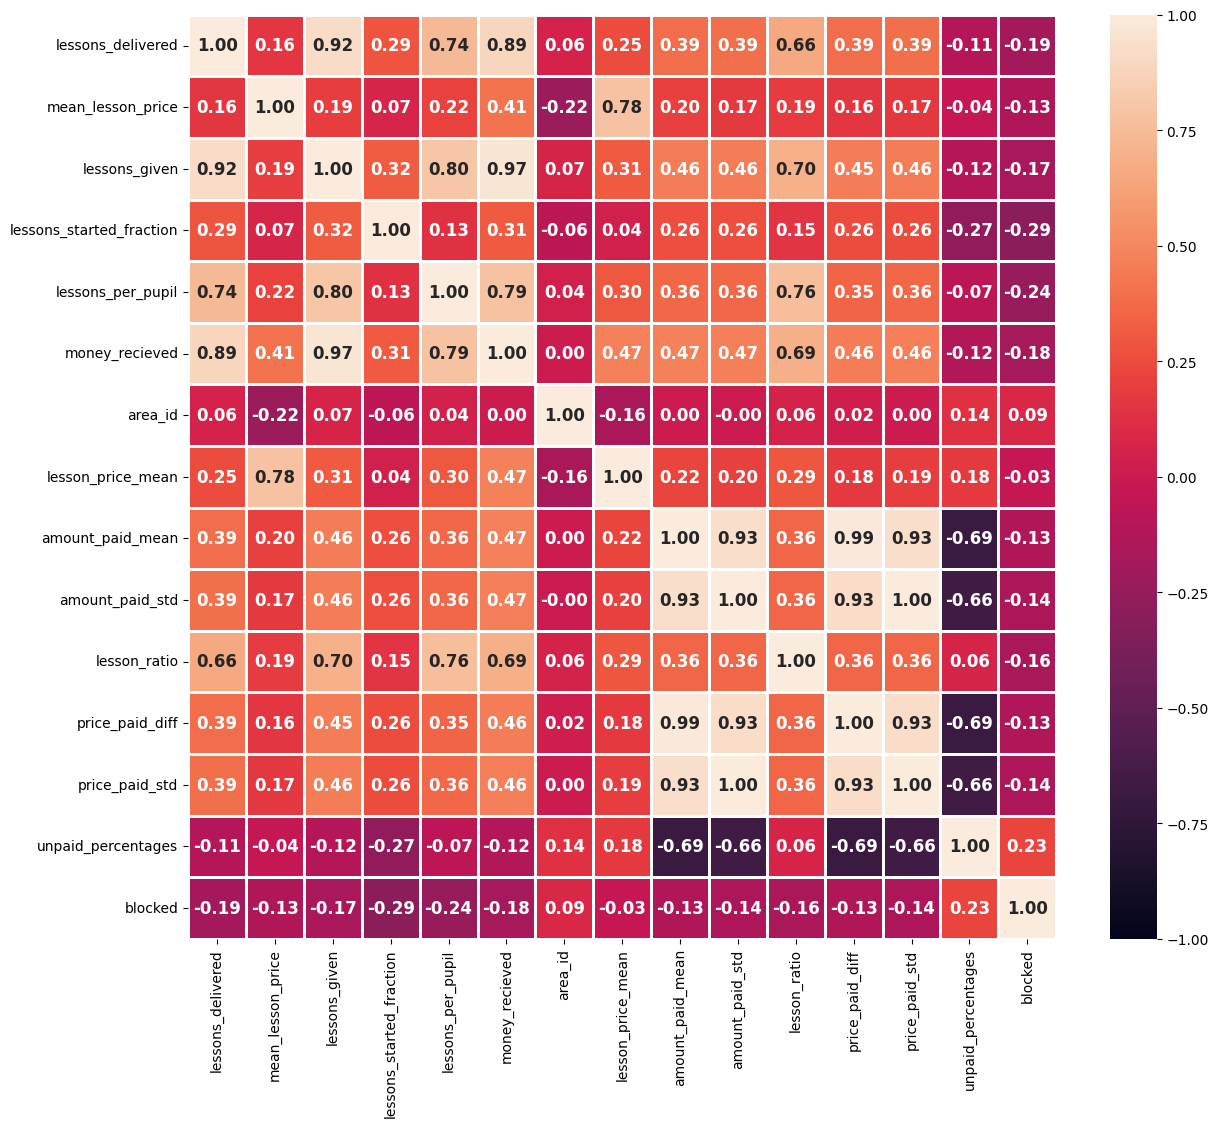

In [17]:
repetit.heatmap(X_train.join(y_train), method='spearman')

Некоторые признаки мультиколлинеарны, в особенности созданные нами. Скорее всего это связано с большим количеством пропусков в данных. Удалим признаки с корреляцией выше **0.8** применив `DropCorrelatedFeatures`.

In [18]:
tr = DropCorrelatedFeatures(method='spearman', threshold=0.8)
tr.fit(X_train)
X_train = tr.transform(X_train)

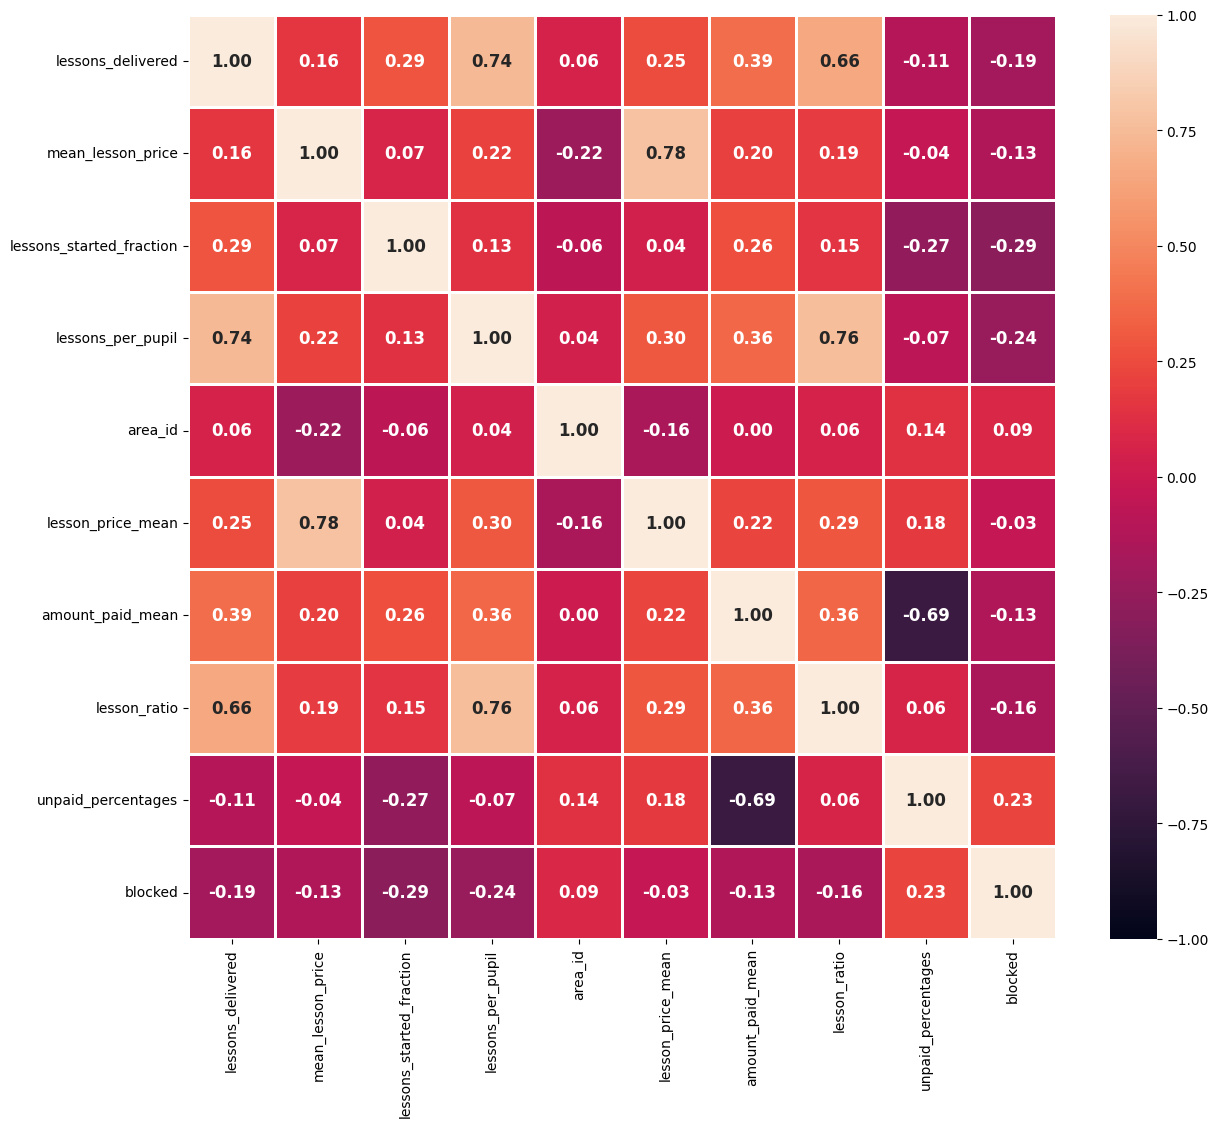

In [19]:
repetit.heatmap(X_train.join(y_train), method='spearman')

In [20]:
repetit.train_models(X_train, y_train)

f1 модели model_LR: **0.5915**

f1 модели model_RFC: **0.5584**

f1 модели model_LGBM: **0.5759**

Метрика почти не изменилась. Построим распределения признаков.

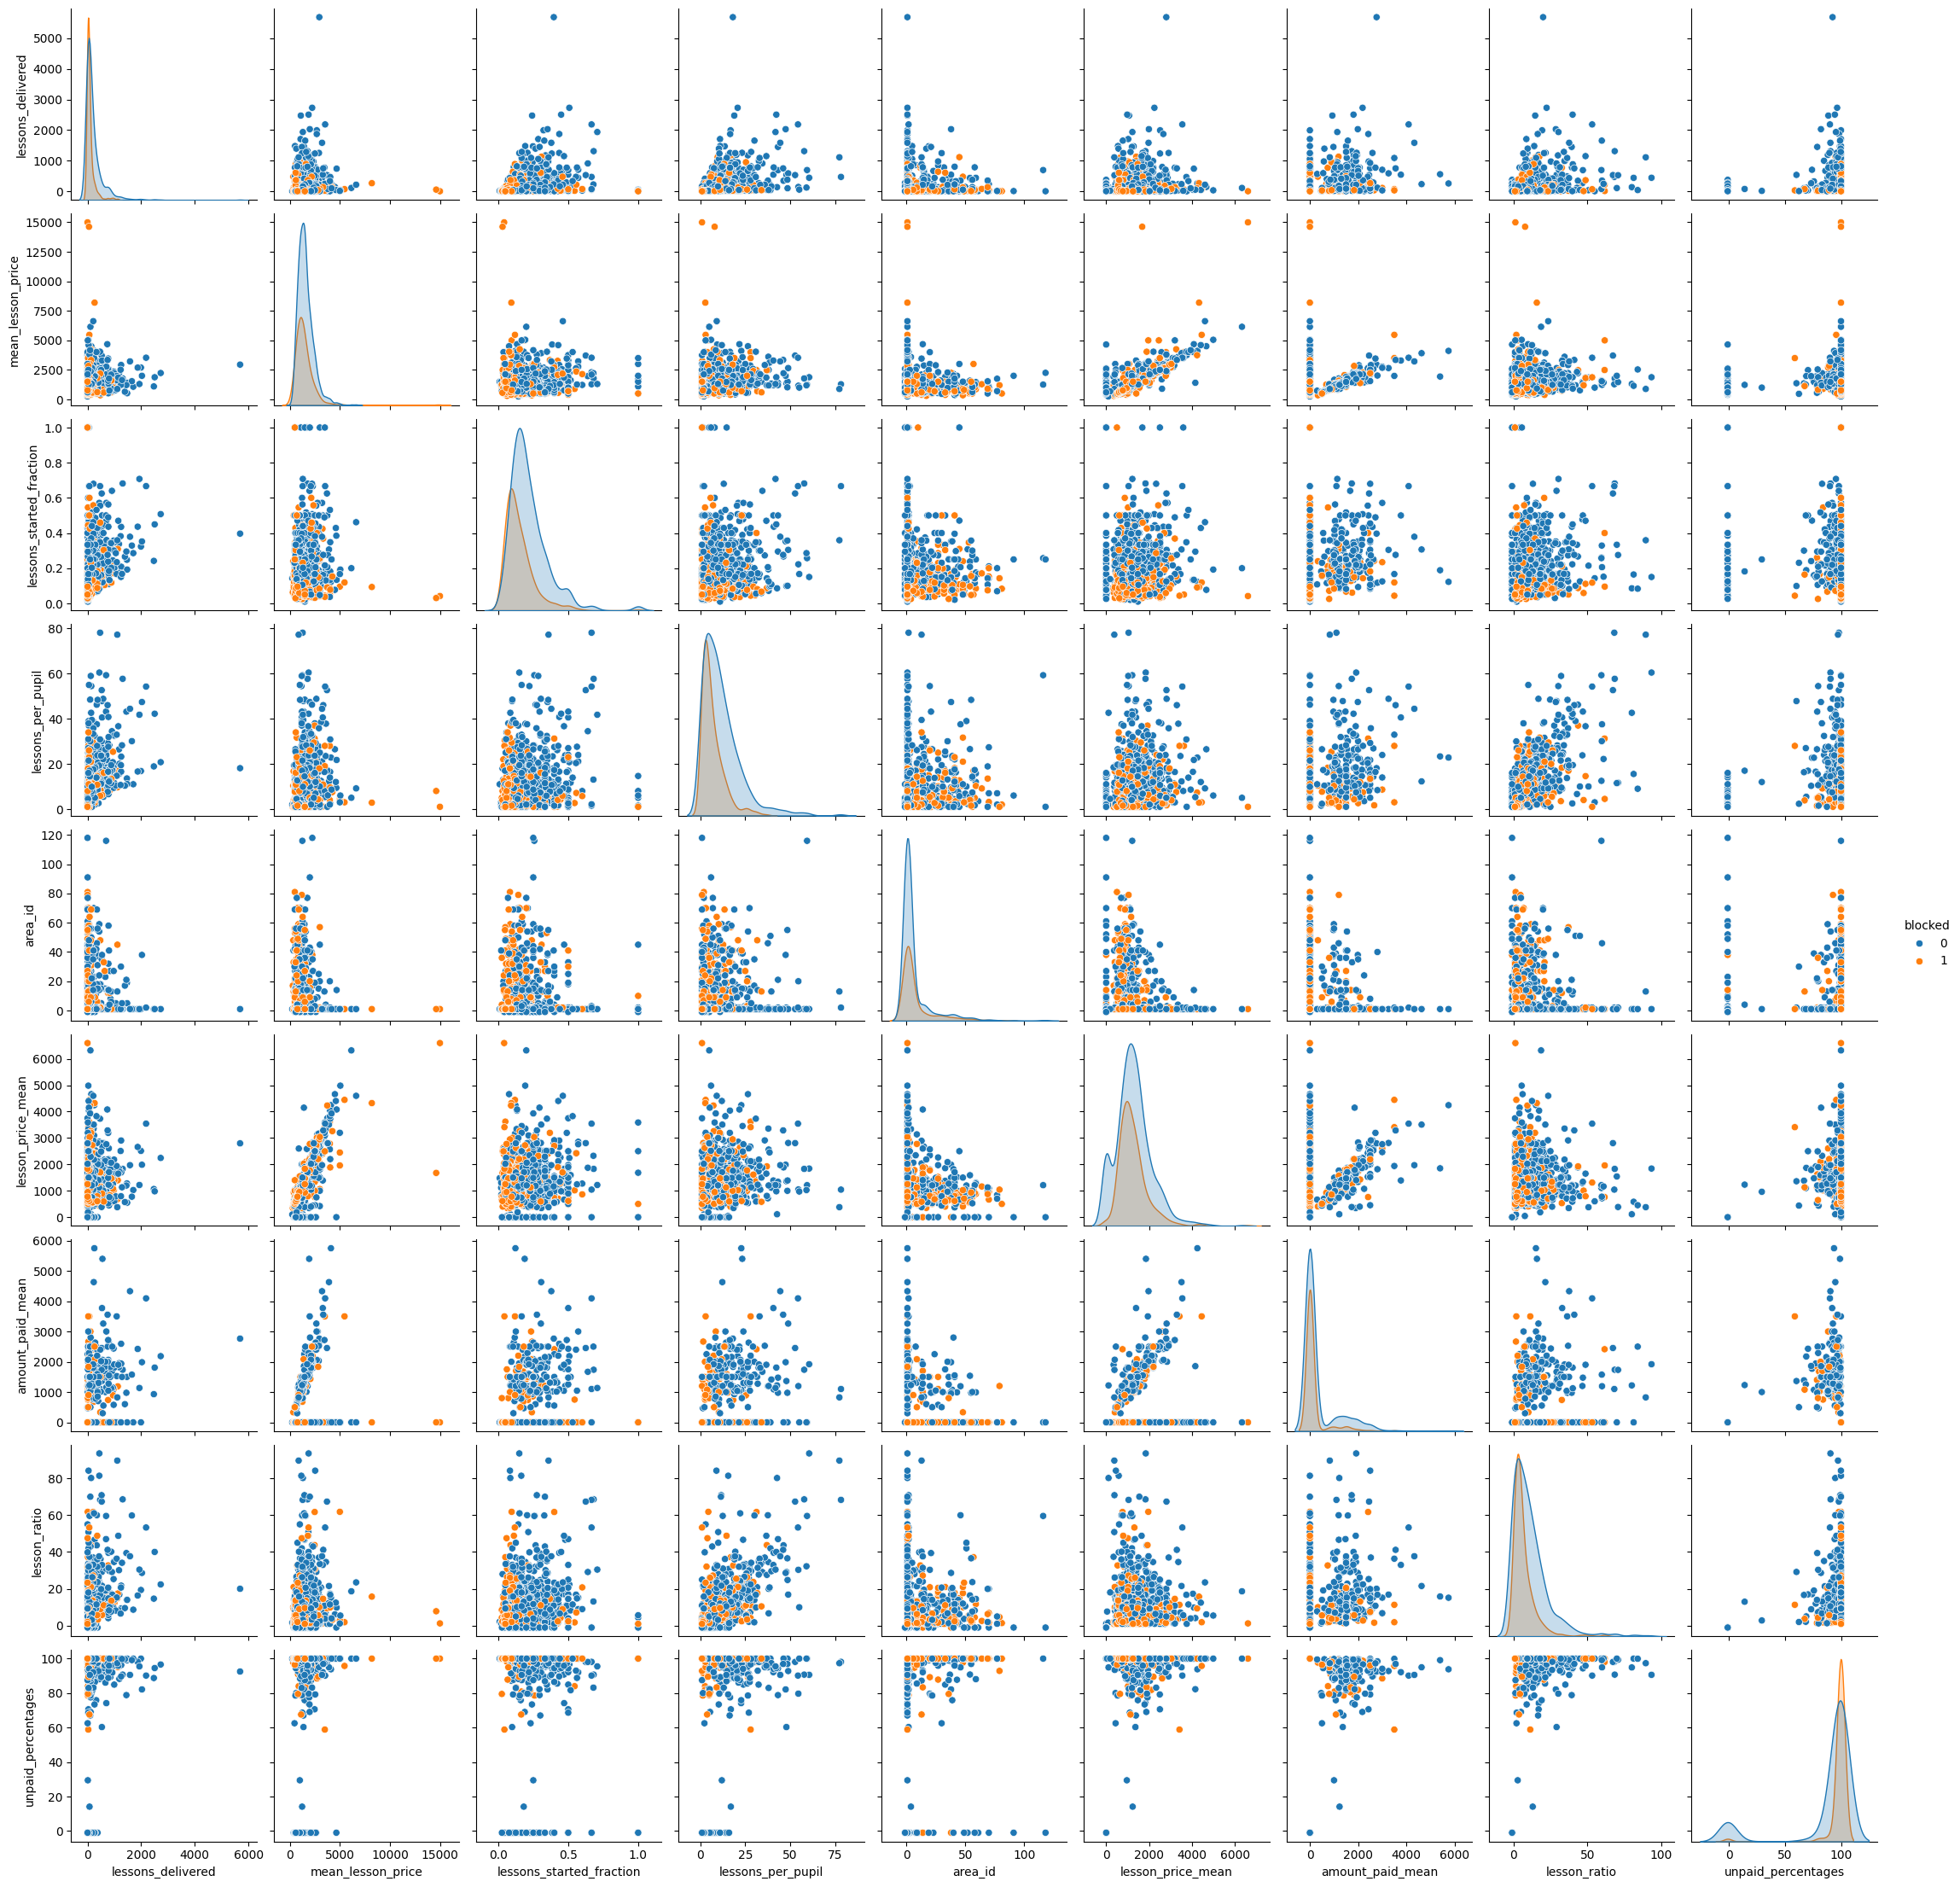

In [21]:
sns.pairplot(X_train.join(y_train), hue='blocked');

Распределения довольно однородны, сложно сказать, какие признаки окажутся полезными. Так же видны выбросы. Устраним их с помощью `IsolationForest`.

### `IsolationForest` <a class="anchor" id="1из_фо"></a>

Удалим 5% выбросов.

In [22]:
IF = IsolationForest(random_state=RANDOM_STATE, contamination=0.05).fit(X_train)
outliers = IF.predict(X_train) == -1
X_train_new = X_train[~outliers]
y_train_new = y_train[y_train.index.isin(X_train_new.index)]

X_train_new.shape

(1257, 9)

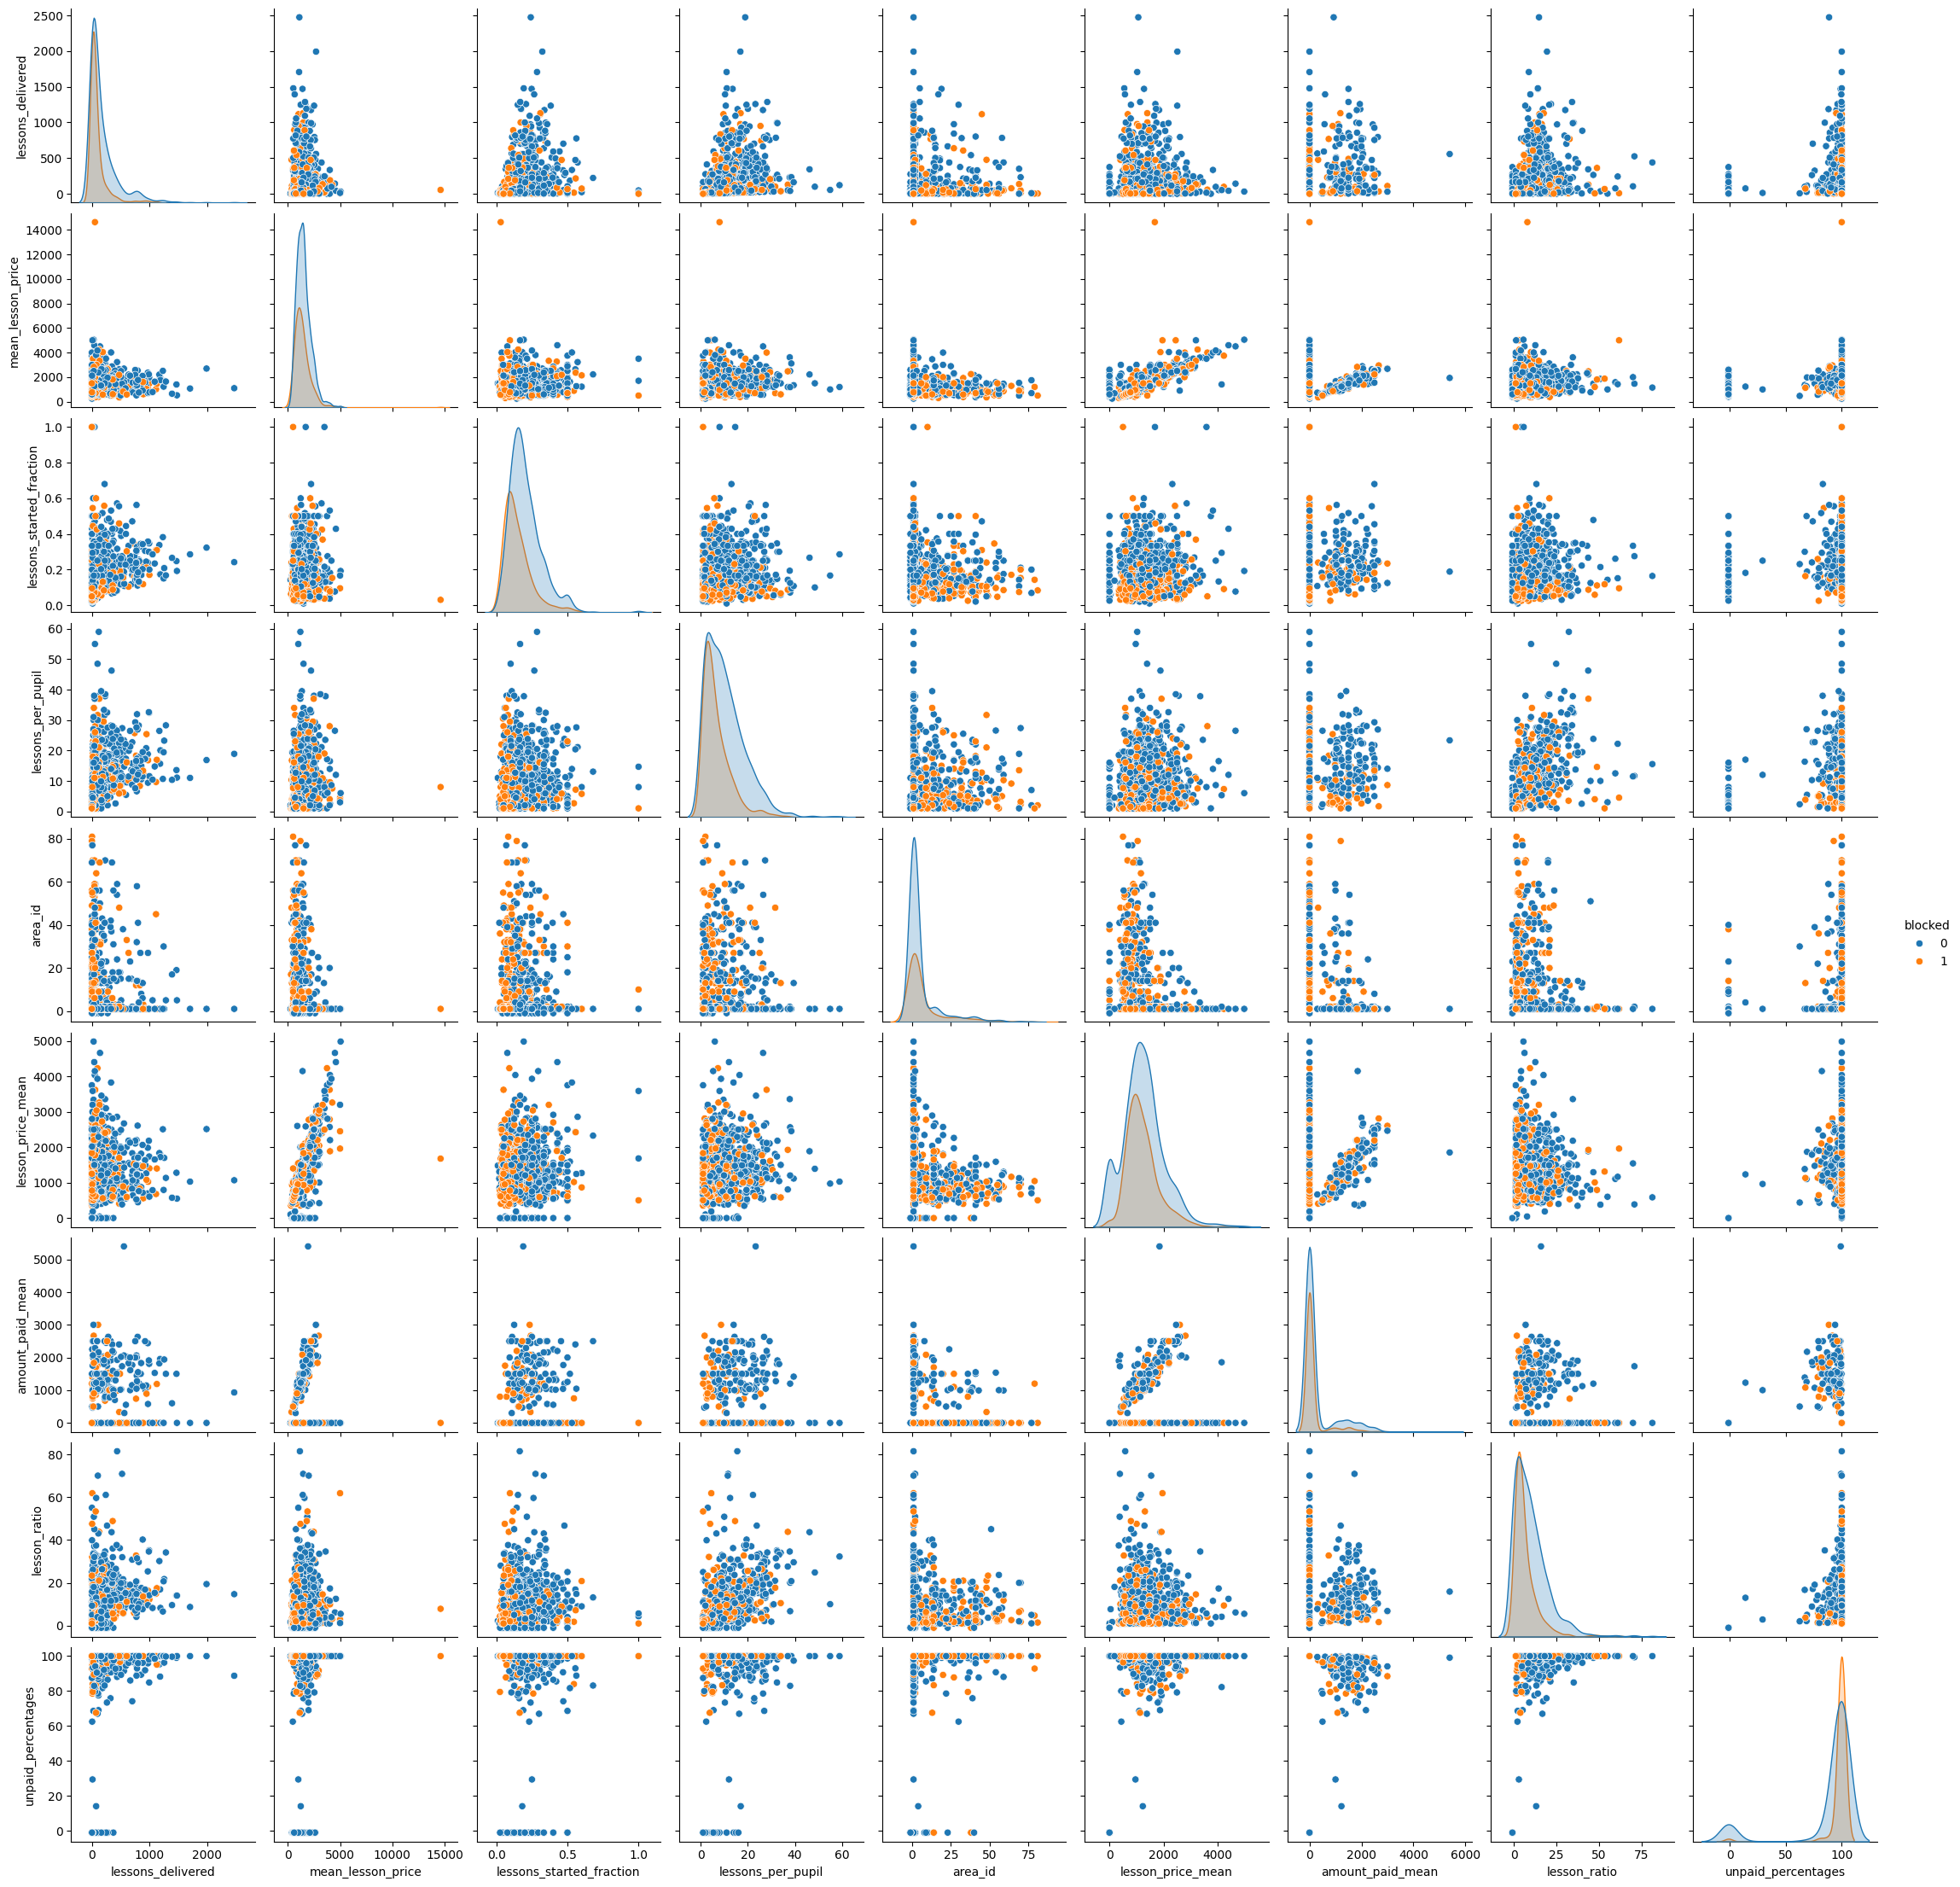

In [23]:
sns.pairplot(X_train_new.join(y_train_new), hue='blocked');

Распределения стали лучше. Проверим, как изменилось качество моделей.

In [24]:
repetit.train_models(X_train_new, y_train_new)

f1 модели model_LR: **0.5765**

f1 модели model_RFC: **0.5298**

f1 модели model_LGBM: **0.5711**

Метрика меняется в рамках погрешности, однако удаление выбросов может помочь в будущем, оставим это изменение данных. Мы уже отбирали признаки по корреляции. Теперь отберём признаки с помощью `SelectKBest`.

In [25]:
X_train, y_train = X_train_new, y_train_new

## `SelectKBest` <a class="anchor" id="1се_бе"></a>

Посмотрим на важность признаков на примере `LGBMClassifier`.

In [26]:
model_LGBM = LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced', verbose=0)
model_LGBM.fit(X_train_new, y_train_new)

LGBMClassifier(class_weight='balanced', random_state=1000000, verbose=0)

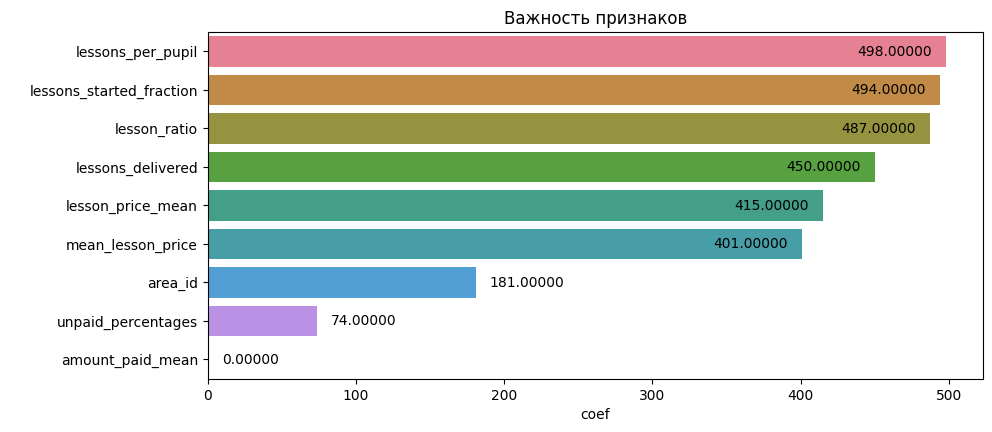

In [27]:
repetit.show_imporatance(X_train.columns, model_LGBM.feature_importances_)

`amount_paid` остался последним из признаков, созданных на основе данных с множеством пропусков. Видно, что он не вносит вклад в результат. Так же `unpaid_percentage` имеет крайне малую важность. Отбросим их. Однако регион оказался немного значимым признаком, а созданный нами ранее `lesson_ratio` вошёл в топ-3.

In [28]:
selector = SelectKBest(score_func=repetit.my_score, k=7)
selector.fit(X_train_new, y_train_new)

selected_features = selector.get_support(indices=True)
selected_columns = X_train_new.columns[selected_features]

X_train_new = pd.DataFrame(selector.transform(X_train_new), columns=selected_columns, index=X_train_new.index)

X_train_new.shape

(1257, 7)

In [29]:
repetit.train_models(X_train_new, y_train_new)

f1 модели model_LR: **0.5901**

f1 модели model_RFC: **0.5421**

f1 модели model_LGBM: **0.5726**

Последний шаг - устранение дисбаланса.

In [30]:
X_train, y_train = X_train_new, y_train_new

## `ADASYN` <a class="anchor" id="1ад"></a>

In [31]:
X_resampled, y_resampled = ADASYN(random_state=RANDOM_STATE).fit_resample(X_train, y_train)
print("Original dataset:", sorted(Counter(y_train_new).items()))
print("Sampled dataset:", sorted(Counter(y_resampled).items()))

Original dataset: [(0, 818), (1, 439)]
Sampled dataset: [(0, 818), (1, 822)]


In [32]:
repetit.train_models(X_resampled, y_resampled)

f1 модели model_LR: **0.6919**

f1 модели model_RFC: **0.7412**

f1 модели model_LGBM: **0.7463**

Метрика на валидации заметно увеличилась, однако сложно сказать, как поведёт себя оценка на тестовой выборке.

Мы обозначили главные пункты предобработки данных. Теперь соберём их в `PipeLine`, для удобства проведения предобработки.

## `Pipeline` <a class="anchor" id="1па"></a>

Единственная проблема заключается в том, что `IsolationForest` не имеет встроенного метода `fit_resample`, который `Pipeline` вызывает в ходе обучения. Поэтому создадим новый класс `IsolationForestTransformer`, который будет наследовать функциональность и свойства класса `IsolationFores` и определим метод `fit_resample`. Да, есть другие методы борьбы с выбросами, которые можно передавать в `Pipeline`, но так интереснее :) Так же стоит отметить, что из-за изменения количества данных нужно использовать `Pipeline` из библиотеки `imblearn`.

In [33]:
class IsolationForestTransformer(IsolationForest):
    def init(self, contamination=0.1, random_state=1, **kwargs):
        super().init(**kwargs)
        self.random_state = random_state
        self.contamination = contamination
        self.model = IsolationForest(contamination=contamination, random_state=random_state)

    def fit_resample(self, X, y):
        self.fit(X)
        y_pred = self.predict(X)
        X_clean = X[y_pred == 1]
        y_clean = y[y_pred == 1]
        return X_clean, y_clean

Так же для логистической регрессии необходимо нормализовать численные значения. Используем `StandardScaler()`, поместив его в `ColumnTransformer`.

In [34]:
num_columns = X_base_train.columns

columns_pipeline = ColumnTransformer([('num_scaler', StandardScaler(), num_columns)], remainder='passthrough')

Теперь соберём `Pipeline`, объединив все рассмотренные ранее методы предобработки. Последним шагом укажем кортеж `('clf', LogisticRegression())`, в который по необходимости будем передавать другие модели.

In [35]:
pipeline = Pipeline([
    ('preprocessing', columns_pipeline),
    ('isolation_forest', IsolationForestTransformer(random_state=RANDOM_STATE, contamination=0.05)),
    ('drop_correlated', DropCorrelatedFeatures(method='spearman', threshold=0.8)),
    ('select_k_best', SelectKBest(score_func=repetit.my_score, k=7)),
    ('ADASYN', ADASYN(random_state=RANDOM_STATE)),
    ('clf', LogisticRegression())
])

pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_scaler',
                                                  StandardScaler(),
                                                  Index(['lessons_delivered', 'mean_lesson_price', 'lessons_given',
       'lessons_started_fraction', 'lessons_per_pupil', 'money_recieved',
       'area_id', 'lesson_price_mean', 'amount_paid_mean', 'amount_paid_std',
       'lesson_ratio', 'price_paid_diff', 'pr...
                ('isolation_forest',
                 IsolationForestTransformer(contamination=0.05,
                                            random_state=1000000)),
                ('drop_correlated', DropCorrelatedFeatures(method='spearman')),
                ('select_k_best',
                 SelectKBest(k=7,
                             score_func=<bound method Repetit.my_score of <Repetit_functions.Repetit object at 0x000001CB69488850>>)),
                ('ADASYN', ADASYN(random_state=1000000)),
                ('clf', LogisticRegression())])

Основнвая метрика в данном проекте - `f1_score`. Однако, заказчику важнее вычислить как можно больше неэффективных преподавателей, при этом допускается совершать ложно-положительные ошибки, так как в дальнейшем, отмеченные нашей моделью положительные объекты будут просматриваться вручную. То есть нам так же интересно оценить вкалд `recall` в метрику. Для этого существует `fbeta_score` с параметром `beta`, который определяет важность `recall`. Поэтому добавим вторую метрику к оценке, создав функцию `my_fb_scorer` с помощью `make_scorer`. Для передачи параметров работы `GridSearchCV` создадиим словарь `grid_params`, в который и поместим словарь с нашими метриками. Так же укажем значение `refit: f1`, чтобы `GridSearchCV` возвращал обученную лучшую модель, выбранную по метрике `f1`. `cv` установим равный 5.

In [36]:
grid_params = {'scoring': {"f1": "f1", "fb_score": repetit.my_fb_scorer()},
               'cv': 5,
               'refit': 'f1'}

Все готово к обучению. Проверим работу `Pipeline` на наших трёх моделях, подбирая гиперпараметры.

In [37]:
params_LR = [{
              'clf': [LogisticRegression(random_state=RANDOM_STATE)],
              'clf__C': [0.01,0.1,1,10],
              'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
              }]

grid_LR = GridSearchCV(pipeline,
                       params_LR,
                       **grid_params)

grid_LR.fit(X_base_train, y_base_train);

In [38]:
repetit.grid_search_results(grid_LR)

Время обучения лучшей модели: **0.2** секунды

f1 на кросс валидации: **0.5956**

fb на кросс валидации: **0.6784**

Наилучший набор параметров: {'clf': LogisticRegression(random_state=1000000), 'clf__C': 0.01, 'clf__solver': 'newton-cg'}

In [39]:
params_RFC = [{
               'clf': [RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
               'clf__max_depth':[2, 4, 10], 
               'clf__n_estimators':[50, 100, 200],
               'clf__min_samples_leaf':[1, 2, 3],
              }]

grid_RFC = GridSearchCV(pipeline,
                        params_RFC,
                        **grid_params) 

grid_RFC.fit(X_base_train, y_base_train);

In [40]:
repetit.grid_search_results(grid_RFC)

Время обучения лучшей модели: **0.32** секунды

f1 на кросс валидации: **0.6178**

fb на кросс валидации: **0.6844**

Наилучший набор параметров: {'clf': RandomForestClassifier(class_weight='balanced', random_state=1000000), 'clf__max_depth': 10, 'clf__min_samples_leaf': 3, 'clf__n_estimators': 50}

In [41]:
params_LGBM = [{
                'clf': [LGBMClassifier(random_state=RANDOM_STATE, verbose=-100, class_weight='balanced')],
                'clf__num_leaves': [30, 60, 90],
                'clf__max_depth': [-1, 10, 30],
                'clf__learning_rate': [0.03, 0.01, 0.03],
                'clf__boosting_type' : ['gbdt', 'dart']
              }]

grid_LGBM = GridSearchCV(pipeline,
                         params_LGBM,
                         **grid_params) 

grid_LGBM.fit(X_base_train, y_base_train);

In [42]:
repetit.grid_search_results(grid_LGBM)

Время обучения лучшей модели: **0.28** секунды

f1 на кросс валидации: **0.5891**

fb на кросс валидации: **0.6159**

Наилучший набор параметров: {'clf': LGBMClassifier(class_weight='balanced', random_state=1000000, verbose=-100), 'clf__boosting_type': 'dart', 'clf__learning_rate': 0.03, 'clf__max_depth': 10, 'clf__num_leaves': 30}

Лучше всего показал себя `RandomForestClassifier`. Так же видно, что `fbeta` оценка немного выше, нежели, `f1`, то есть наши модели одинаково ориентированы на лучшее предсказание `recall`, нежели `precision`, так что они все нам подходят.

Но что если с данными будет работать не одна модель, а сразу несколько? Рассмотрим работу метода **стэккинг**.

## `StackingClassifier` <a class="anchor" id="1ст_кл"></a>

В этом методе используется несколько моделей, на предсказаниях которых обучается мета-модель, которая, в свою очередь, и реализует предсказание целевого признака. Для этого возьмём уже обученные нами три модели и добавим к ним несколько классификаторов. Заменим последний шаг в `pipeline` на кортеж `('ensemble', St_clf)`, а в качестве мета-модели выберем `LogisticRegression`.

In [43]:
pipeline = Pipeline([
    ('preprocessing', columns_pipeline),
    ('isolation_forest', IsolationForestTransformer(random_state=RANDOM_STATE, contamination=0.05)),
    ('drop_correlated', DropCorrelatedFeatures(method='spearman', threshold=0.8)),
    ('select_k_best', SelectKBest(score_func=repetit.my_score, k=7)),
    ('ADASYN', ADASYN(random_state=RANDOM_STATE)),
    ('clf', LogisticRegression())
])

In [44]:
model_LR = grid_LR.best_estimator_[5]
model_RFC = grid_RFC.best_estimator_[5]
model_LGBM = grid_LGBM.best_estimator_[5]
model_GNB = GaussianNB()
model_KNC = KNeighborsClassifier(n_neighbors=50)

estimators = [
     ('LR', model_LR),
     ('RFC', model_RFC),
     ('LGBM', model_LGBM),
     ('GNB', model_GNB),
     ('KNC', model_KNC)     
 ]

In [45]:
St_clf = StackingClassifier(
                            estimators=estimators,
                            final_estimator=LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced'),
                            stack_method='predict_proba'
                           )

In [46]:
pipeline_st_clf = deepcopy(pipeline)

pipeline_st_clf.steps[-1] = ('ensemble', St_clf)

In [47]:
params_st_clf = dict()

grid_st_clf = GridSearchCV(pipeline_st_clf,
                        params_st_clf,
                        **grid_params) 

grid_st_clf.fit(X_base_train, y_base_train);

In [48]:
repetit.grid_search_results(grid_st_clf)

Время обучения лучшей модели: **1.35** секунды

f1 на кросс валидации: **0.6265**

fb на кросс валидации: **0.6566**

Наилучший набор параметров: {}

Не самый лучший результат. Теперь выберем три модели, показавших наилучшие метрики на валидации и протестируем их на тестовых данных. 

## Тестирование лучших моделей <a class="anchor" id="1те_лу"></a>

Метрику на тестовой выборке будем смотреть у `grid_st_clf`, `grid_RFC` и `grid_LR`.

In [49]:
display(Markdown(f'f1 модели на тестовой выборке: **{f1_score(y_test, grid_st_clf.predict(X_test)):.4}**'))

f1 модели на тестовой выборке: **0.685**

In [50]:
display(Markdown(f'f1 модели на тестовой выборке: **{f1_score(y_test, grid_RFC.predict(X_test)):.4}**'))

f1 модели на тестовой выборке: **0.6795**

In [51]:
display(Markdown(f'f1 модели на тестовой выборке: **{f1_score(y_test, grid_LR.predict(X_test)):.4}**'))

f1 модели на тестовой выборке: **0.625**

`grid_st_clf` немного опередил `grid_RFC`, однако если сравнивать скорость работы, задействованные ресурсы и интерпретируемость, то `grid_RFC` выигрывает с большим отрывом. Выберем его в качестве финальной модели и посмотрим на матрицу ошибок.

## Матрица ошибок <a class="anchor" id="1ма_ош"></a>

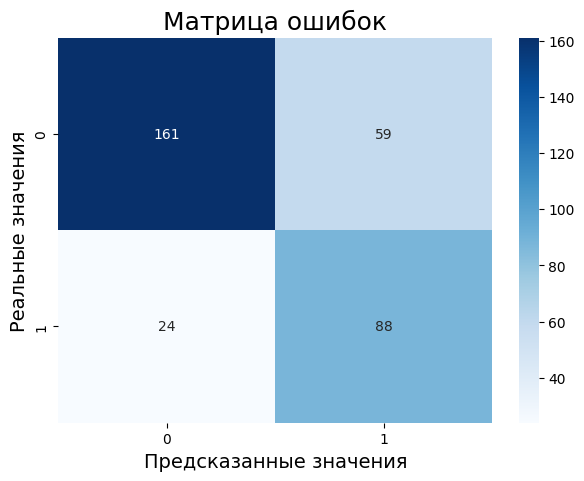

In [52]:
threshold = 0.5

predictions = grid_RFC.predict_proba(X_test)[:,1] >= threshold 
repetit.confusion_matrix_heatmap(y_test, predictions)

Не так много ответов являются ложноотрицательными. Так же это можно попробовать регулировать с помощью *порога классификации*. Сначала зафиксируем результат:<br>
Всего неэффективных преподавателей: 24+88=**112** <br>
Предложено к проверке: 59+88=**147** <br>
Верно вычислено нэффективных: **88** или **79%** от **112** <br>
Упущено: **24** или **21%** от **112** <br>
"Лишних" преподавателей в проверке: **59** или **40%** от **147**<br>
Ручная проверка сокращена на: $\ 1- \Large \frac{88+59}{161+59+24+88}$ = **56%**

f1 модели на тестовой выборке: **0.6553**

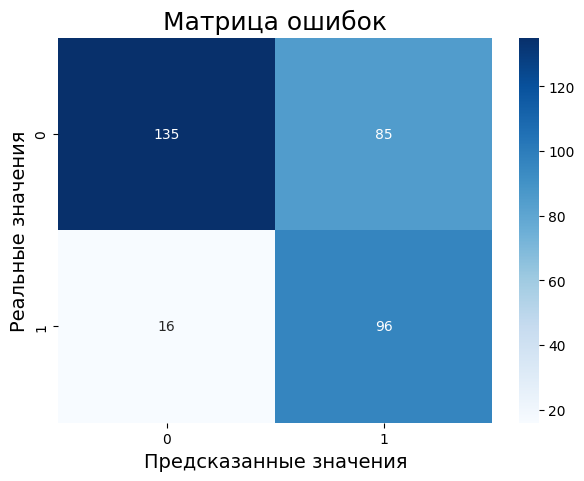

In [53]:
threshold = 0.4

predictions = grid_RFC.predict_proba(X_test)[:,1] >= threshold 

display(Markdown(f'f1 модели на тестовой выборке: **{f1_score(y_test, predictions):.4}**'))
repetit.confusion_matrix_heatmap(y_test, predictions)

При пороге классификации **0.4** мы получили следующую ситуацию:<br>
Всего неэффективных преподавателей: **112** <br>
Предложено к проверке: 85+96=**181** <br>
Верно вычислено: **90** или **85** от **112** <br>
Упущено: **16** или **14%** от **112** <br>
"Лишних" преподавателей в проверке: **85** или **46%** от **181** <br>
Ручная проверка сокращена на: $\ 1- \Large \frac{85+96}{332}$ = **45%**

На **8** верно вычисленных неэффективных преподавателей добавилось **24** эффективных преподавателей к проверке. Таким образом заказчик с помощью порога классификации может балансировать между точностью определения неэффективных преподавателей и объёмом ручной проверки.

## Выводы <a class="anchor" id="1вы"></a>

Целью данного проекта являлась разработка модели для классификации учителей на платящих и неэффективных. Оценка качества модели проводится с помощью метрики `f1`. Для этого предоставленны данные, содержащие информацию о репетиторах, заявках и уроках, а так же датасет с генерированными заказчиком признаками и разметкой на платящих и неэффективных преподавателей. По результатам работы разработан классификатор на основе `RandomForestClassifier`, показавший на тестовой выборке  метрику `f1` равную **0.6795**. Преподготовка данных для обучения модели состояла из ручной генерации признаков и обработки с помощью `pipeline`.

В ходе проекта был проведен обзор данных, который показал небольшое количество размеченных объектов: 1656 и большое количество пропусков в данных об оплате уроков: всего 8143 не пустых значения из 1191127, что составляет меньше процента, что поставило под сомнение возможность эффективной генерации значимых признаков. На вопросы о природе пропусков и возможности их устранения заказчик не ответил, поэтому пришлось работать с этими данными. Так же обнаружен дисбаланс целевого признака 1:2 и выбраны потенциально полезные признаки.

Далее созданы новые признаки `price_paid_std`, `unpaid_percentages`, `lesson_price_mean`, `amount_paid_mean`, `amount_paid_std`, `price_paid_diff` и `lesson_ratio`. Основная идея генерации признаков взята из ТЗ - отобразить непостоянство преподавателей, так как у неэффективных преподавателей стоимости уроков отличаются.

В качестве базовых моделей для исследования выбраны `LogisticRegression`, `RandomForestClassifier` и `LGBMClassifier`.

Для улучшения тренировочных данных по итогам предобработки выбраны следующие методы и их параметры: **DropCorrelatedFeatures(method='spearman', threshold=0.8)**, **Isolation Forest(contamination=0.05)**, **SelectKBest(score_func=repetit.my_score, k=7)** и **ADASYN()**.

Все методы объедены в `pipeline` для потоковой обработки данных. Параметры моделей подбирались с помощью `GridSearchCV` и оценивались по метрикам `f1` и `fbeta`, что реализовано через мультискоринг.
Дополнительно построен `StackingClassifier`, в который в качестве базовых моделей были добавлены три уже исследованных классификатора и ещё два более простых. Мета-модель: `LogisticRegression`.

Реализовано тестирование на тестовой выборке трёх лучших моделей `grid_st_clf`, `grid_RFC` и `grid_LR`. Финальной моделью выбран `grid_RFC` за его хорошую метрику, быстродействие и интерпретируемость. Его структура проиллюстрирована ниже.

Рассмотрена матрица ошибок финальной модели. Видно, что наш классификатор позволяет на **56%** сократить время на ручную проверку, пропуская всего **21%** неэффективных преподавателей. Изменив порог классификации на **0.4** можно снизить до **14%** количество упущенных преподавателей, но при этом время на ручную проверку сократится на **45%**.

In [54]:
grid_RFC.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_scaler',
                                                  StandardScaler(),
                                                  Index(['lessons_delivered', 'mean_lesson_price', 'lessons_given',
       'lessons_started_fraction', 'lessons_per_pupil', 'money_recieved',
       'area_id', 'lesson_price_mean', 'amount_paid_mean', 'amount_paid_std',
       'lesson_ratio', 'price_paid_diff', 'pr...
                ('drop_correlated', DropCorrelatedFeatures(method='spearman')),
                ('select_k_best',
                 SelectKBest(k=7,
                             score_func=<bound method Repetit.my_score of <Repetit_functions.Repetit object at 0x000001CB81038940>>)),
                ('ADASYN', ADASYN(random_state=1000000)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_leaf=3, n_estimators=50,
                                        random_state=1000000))])